<a href="https://colab.research.google.com/github/Alenushka2013/Coursera/blob/master/240191_Time_series_analysis_%D0%9F%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D0%B5_%D0%BE%D1%82%D1%82%D0%BE%D0%BA%D0%B0_%D0%BA%D0%BB%D0%B8%D0%B5%D0%BD%D1%82%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование оттока банковских счетов клиента

# 📊 **План семинара**:


## 1. Считывание данных

* Загрузим исходный датасет и ознакомимся с его структурой.

## 2. Анализ целевой переменной

* Посмотрим на распределение и характеристики целевой переменной, чтобы лучше понять задачу.


## 3. Первичная предобработка данных

* Подготовим данные к моделированию: обработаем пропуски, преобразуем категориальные признаки и нормализуем числовые.


## 4. Обучение первой модели и оценка качества

* Обучим базовую модель на подготовленных данных.
* Оценим её качество на тестовой выборке с помощью метрик классификации.


## 5. Анализ ошибок и Data Leak

* Разберёмся, какие ошибки могли возникнуть, и выявим, произошёл ли "утекание данных" (Data Leak) из будущего в прошлое.


## 6. Корректная предобработка данных

* Выполним правильную обработку данных с учётом временной структуры: создадим лаговые признаки, исключим возможность утечки данных.


## 7. Обучение корректной модели и оценка качества

* Обучим модель на корректно подготовленных данных.
* Сравним её качество с предыдущим результатом и обсудим улучшения.


## 8. Итоговые выводы

* Подведём итоги семинара, выделим основные моменты работы с последовательными данными и важность правильной подготовки данных.


# 1. 💻 Импорт библиотек

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, f1_score
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [ ]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [ ]:
SEED = 17

In [ ]:
data = pd.read_csv("train.csv")

# 2. 🎯 Анализ целевой переменной


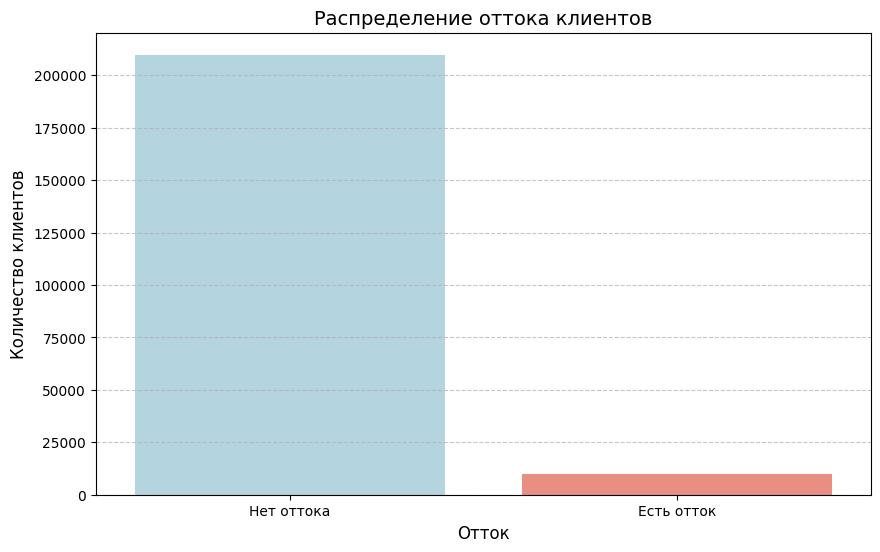

In [ ]:
churn_by_client = data.groupby('npo_account_id')['churn'].unique()
churn_by_client = churn_by_client.apply(lambda x: x[0])
churn_df = pd.DataFrame(churn_by_client, columns=['churn']).reset_index()


plt.figure(figsize=(10, 6))
sns.countplot(x='churn', data=churn_df, palette=['lightblue', 'salmon'])
plt.title('Распределение оттока клиентов', fontsize=14)
plt.xlabel('Отток', fontsize=12)
plt.ylabel('Количество клиентов', fontsize=12)
plt.xticks([0, 1], ['Нет оттока', 'Есть отток'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 2.1 🎯 Задача:  ```Предсказать закрытие счёта клиента в следующем квартале```

In [ ]:
data[data['npo_account_id']=='0x17AA4D9556DBC64DA3D6BD7F1C1B9F0C']. \
        sort_values(by='quarter')[['npo_account_id', 'quarter', 'churn']]. \
        reset_index(drop=True).tail(10)

,npo_account_id,quarter,churn
14,0x17AA4D9556DBC64DA3D6BD7F1C1B9F0C,2017Q4,0
15,0x17AA4D9556DBC64DA3D6BD7F1C1B9F0C,2018Q1,0
16,0x17AA4D9556DBC64DA3D6BD7F1C1B9F0C,2018Q3,0
17,0x17AA4D9556DBC64DA3D6BD7F1C1B9F0C,2018Q4,0
18,0x17AA4D9556DBC64DA3D6BD7F1C1B9F0C,2019Q1,0
19,0x17AA4D9556DBC64DA3D6BD7F1C1B9F0C,2019Q2,0
20,0x17AA4D9556DBC64DA3D6BD7F1C1B9F0C,2019Q4,0
21,0x17AA4D9556DBC64DA3D6BD7F1C1B9F0C,2020Q1,0
22,0x17AA4D9556DBC64DA3D6BD7F1C1B9F0C,2020Q2,0
23,0x17AA4D9556DBC64DA3D6BD7F1C1B9F0C,2020Q4,1


### 📌 Вывод по клиенту:

Мы наблюдаем, что клиент активно пользовался счётом на протяжении нескольких кварталов, однако полностью перестал им пользоваться начиная с **2020Q4** 📅. Это подтверждает необходимость учитывать временную динамику и лаговые признаки при построении модели предсказания оттока.


In [ ]:
churn_by_period = data[data['churn'] == 1].groupby('quarter').size().reset_index(name='churn_count')  # Группировка данных по кварталам и подсчет оттока
churn_by_period['year'] = churn_by_period['quarter'].str[:4]  # Извлечение года из квартала
churn_by_period['quarter_num'] = churn_by_period['quarter'].str[-2:]  # Извлечение номера квартала
churn_by_period = churn_by_period.sort_values(['year', 'quarter_num'])  # Сортировка по году и кварталу

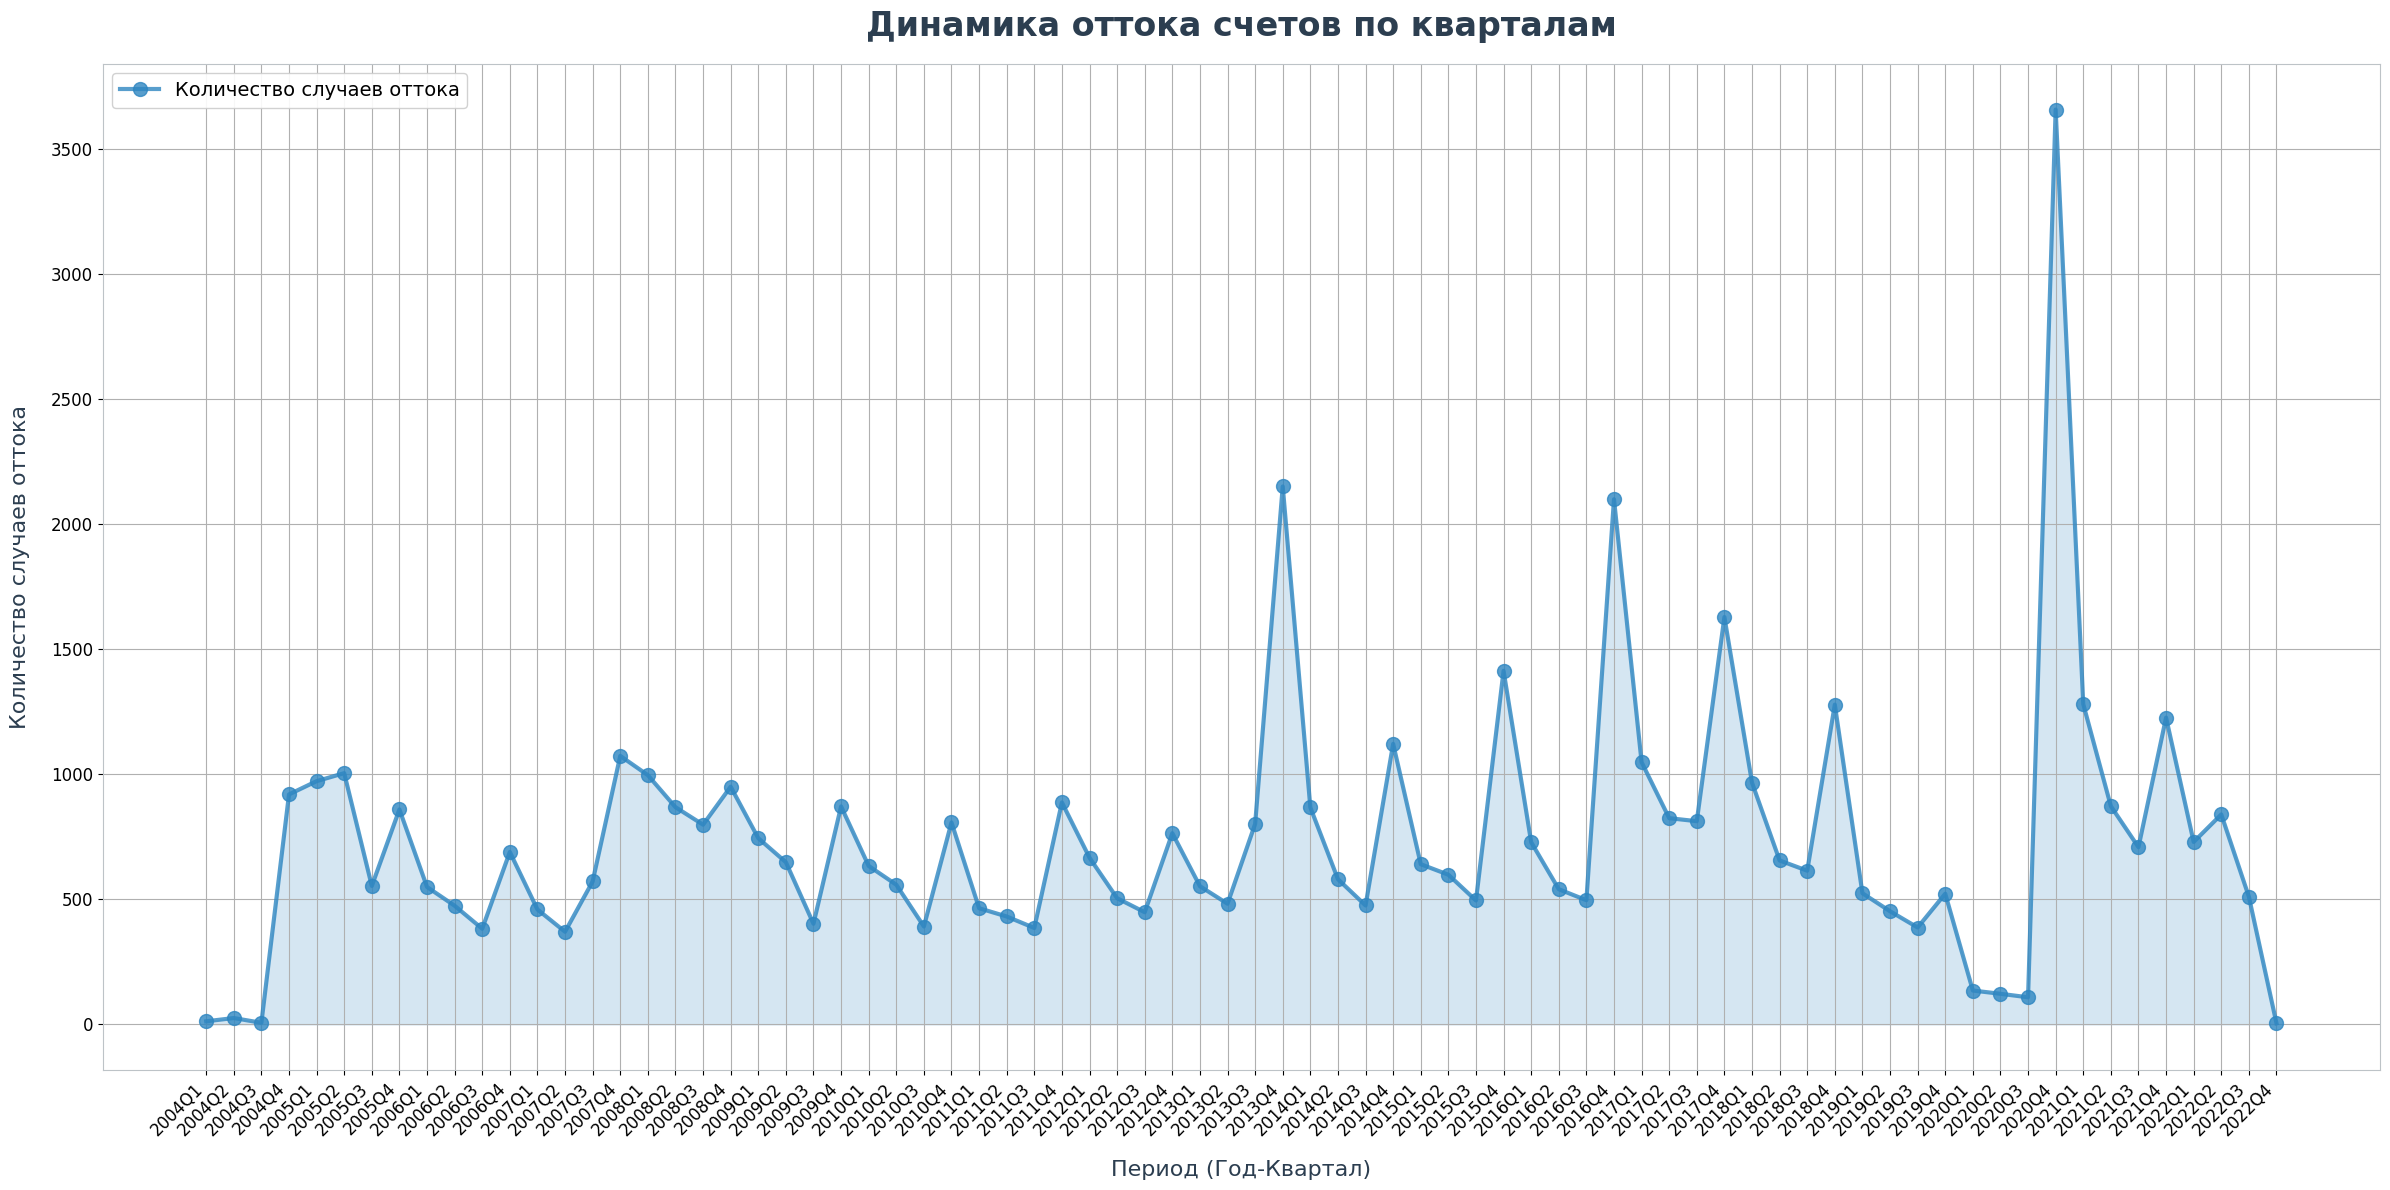

In [ ]:
fig, ax = plt.subplots(figsize=(24, 12))  # Создание фигуры с заданным размером
x_values = range(len(churn_by_period))  # Создание последовательности для оси X
y_values = churn_by_period['churn_count']  # Значения для оси Y

plt.plot(x_values, y_values, marker='o', markersize=10, color='#2E86C1',
         linewidth=3, label='Количество случаев оттока', alpha=0.8)  # Построение графика с маркерами
plt.fill_between(x_values, y_values, alpha=0.2, color='#2E86C1')  # Заливка области под графиком

plt.title('Динамика оттока счетов по кварталам',
         fontsize=24, pad=20, color='#2C3E50', weight='bold')  # Заголовок графика
plt.xlabel('Период (Год-Квартал)', fontsize=16, labelpad=15, color='#2C3E50')  # Подпись оси X
plt.ylabel('Количество случаев оттока', fontsize=16, labelpad=15, color='#2C3E50')  # Подпись оси Y

plt.xticks(ticks=x_values, labels=churn_by_period['quarter'], rotation=45, ha='right', fontsize=12)  # Настройка меток оси X
plt.yticks(fontsize=12)  # Настройка размера шрифта меток оси Y

plt.grid(True)  # Включение сетки
plt.legend(fontsize=14, loc='upper left', framealpha=0.9)  # Настройка легенды
plt.tight_layout()  # Автоматическая настройка расположения элементов

for spine in plt.gca().spines.values():  # Настройка внешнего вида графика
    spine.set_color('#BDC3C7')  # Цвет границ
    spine.set_linewidth(0.8)  # Толщина линий

plt.show()

## 2.2 📌 Выводы по целевой переменной:

* **Значительный дисбаланс классов**: подавляющее большинство клиентов (более 200 тыс.) не покидают банк, в то время как отток происходит у значительно меньшей части клиентов (менее 20 тыс.). Это требует особого подхода при обучении модели (балансировка данных, подбор метрик).

* **Временная структура данных**: динамика оттока клиентов имеет выраженные всплески, особенно заметные в некоторых кварталах, что указывает на наличие сезонности и/или специфических внешних событий, влияющих на решение клиентов покинуть банк.


In [ ]:
print('Количество уникальных регионов:', data['region'].nunique())

Количество уникальных регионов: 448


# 3. 🛠️ Первичная предобработка данных

## 3.1 🧹 Приведение названий регионов к единому формату

In [ ]:
rename_list = [('АДЫГЕЯ РЕСП', 'АДЫГЕЯ РЕСП.'),
 ('АЛТАЙСКИЙ КРАЙ.', 'АЛТАЙСКИЙ КРАЙ', 'АЛТАЙСКИЙ'),
 ('АЛЬШЕЕВСКИЙ Р-Н', 'АЛЬШЕЕВСКИЙ'),
 ('АРХАНГЕЛЬСКАЯ ОБЛ.', 'АРХАНГЕЛЬСКАЯ', 'АРХАНГЕЛЬСКИЙ', 'АРХАНГЕЛЬСКАЯ ОБЛ'),
 ('АУРГАЗИНСКИЙ', 'АУРГАЗИНСКИЙ Р-Н'),
 ('БАШКОРТОСТАН РЕСП.',
  'БАШКОРТОСТАН',
  'БАШКОРТОСТАН РЕСП',
  'РЕСП БАШКОРТОСТАН'),
 ('БЕЛАРУСЬ, МИНСКАЯ ОБЛ',
  'БЕЛАРУСЬ РЕСП',
  'БЕЛАРУСЬ РЕСП.',
  'БЕЛАРУСЬ'),
 ('БЕЛГОРОДСКАЯ', 'БЕЛГОРОДСКИЙ', 'БЕЛГОРОДСКАЯ ОБЛ'),
 ('БЕЛЕБЕЕВСКИЙ Р-Н', 'БЕЛЕБЕЕВСКИЙ'),
 ('БЕЛОРЕЦКИЙ', 'БЕЛОРЕЦКИЙ Р-Н'),
 ('БИЖБУЛЯКСКИЙ', 'БИЖБУЛЯКСКИЙ Р-Н'),
 ('БРЕСТСКАЯ ОБЛ', 'БРЕСТСКИЙ'),
 ('БРЯНСКАЯ', 'БРЯНСКАЯ ОБЛ', 'БРЯНСКАЯ ОБЛ.'),
 ('БРЯНСКАЯ ОБЛ', 'БРЯНСКАЯ ОБЛ.'),
 ('ВАСИЛЕОСТРОВСКИЙ', 'ЛОСИНООСТРОВСКИЙ'),
  ('ВОЛГОГРАДСКАЯ ОБЛ.', 'ВОЛГОГРАДСКАЯ ОБЛ', 'ВОЛГОГРАДСКАЯ'),
 ('ВОЛОГОДСКАЯ ОБЛ', 'ВОЛОГОДСКАЯ'),
 ('ВОРОНЕЖСКАЯ ОБЛ', 'ВОРОНЕЖСКАЯ'),
 ('Г МОСКВА', 'МОСКВА'),
 ('ГОМЕЛЬСКАЯ ОБЛ',
  'БЕЛАРУСЬ, ГОМЕЛЬСКАЯ ОБЛ',
  'ГОМЕЛЬСКАЯ ОБЛАСТЬ',
  'ГОМЕЛЬСКИЙ'),
 ('ДАВЛЕКАНОВСКИЙ Р-Н', 'ДАВЛЕКАНОВСКИЙ'),
 ('ДАГЕСТАН РЕСП', 'ДАГЕСТАН'),
 ('ДОНЕЦКАЯ НАРОДНАЯ РЕСП', 'ДОНЕЦКАЯ НАРОДНАЯ РЕСП.'),
 ('ДЮРТЮЛИНСКИЙ', 'ДЮРТЮЛИНСКИЙ Р-Н', 'ДЮРТЮЛИНСКИЙ РАЙОН'),
 ('ЕРМЕКЕЕВСКИЙ РАЙОН', 'ЕРМЕКЕЕВСКИЙ'),
 ('ЗАБАЙКАЛЬСКИЙ', 'ЗАБАЙКАЛЬСКИЙ КРАЙ.', 'ЗАБАЙКАЛЬСКИЙ КРАЙ'),
 ('ЗИАНЧУРИНСКИЙ', 'ЗИАНЧУРИНСКИЙ Р-Н'),
 ('ИВАНО-ФРАНКОВСКАЯ',
  'УКРАИНА, ИВАНО-ФРАНКОВСКАЯ ОБЛ.',
  'ИВАНО-ФРАНКОВСКАЯ ОБЛ'),
 ('ИГЛИНСКИЙ', 'ИГЛИНСКИЙ Р-Н'),
 ('ИЛИШЕВСКИЙ', 'ИЛИШЕВСКИЙ Р-Н'),
 ('ИНГУШЕТИЯ РЕСП', 'ИНГУШЕТИЯ'),
 ('ИРКУТСКАЯ ОБЛ', 'ИРКУТСКАЯ ОБЛ.'),
 ('ИРКУТСКАЯ ОБЛ', 'ИРКУТСКАЯ ОБЛ.', 'ИРКУТСКАЯ'),
 ('ИСИЛЬКУЛЬСКИЙ', 'ИСИКУЛЬСКИЙ'),
 ('ИШИМБАЙИСКИЙ', 'ИШИМБАЙСКИЙ Р-Н', 'ИШИМБАЙСКИЙ'),
 ('КАЗАХСТАН', 'КАЗАХСТАН, ВОСТОЧНО-КАЗАХСТАНСКАЯ ОБЛ'),
 ('КАЛИНИНГРАДСКАЯ', 'КАЛИНИНГРАДСКАЯ ОБЛ'),
 ('КАЛТАСИНСКИЙ Р-Н', 'КАЛТАСИНСКИЙ'),
 ('КАМЧАТСКАЯ ОБЛ', 'КАМЧАТСКИЙ КРАЙ'),
 ('КАРАЧАЕВО-ЧЕРКЕССКАЯ', 'КАРАЧАЕВО-ЧЕРКЕССКАЯ РЕСП', 'КАРАЧАЕВСКИЙ'),
 ('КАРМАСКАЛИНСКИЙ Р-Н', 'КАРМАСКАЛИНСКИЙ'),
 ('КЕМЕРОВСКАЯ ОБЛАСТЬ - КУЗБАСС ОБЛ',
  'КЕМЕРОВСКАЯ ОБЛ',
  'КЕМЕРОВСКАЯ ОБЛАСТЬ - КУЗБАСС.',
  'КЕМЕРОВСКАЯ ОБЛАСТЬ - КУЗБАСС'),
 ('КИНЕЛЬ-ЧЕРКАССКИЙ', 'КИНЕЛЬ - ЧЕРКАССКИЙ'),
 ('КИРОВСКАЯ ОБЛ.', 'КИРОВСКАЯ ОБЛ', 'КИРОВСКАЯ', 'КИРОВСКИЙ'),
 ('КОМИ РЕСП.', 'КОМИ РЕСП'),
 ('КРАСНОДАРСКИЙ', 'КРАСНОДАРСКИЙ КРАЙ', 'КРАСНОДАРСКИЙ КРАЙ.'),
 ('КРАСНОКАМСКИЙ', 'КРАСНОКАМСКИЙ Р-Н'),
 ('КРАСНОСЕЛЬКУПСКИЙ', 'КРАСНОСЕЛЬСКИЙ'),
 ('КРАСНОЯРСКИЙ КРАЙ.', 'КРАСНОЯРСКИЙ', 'КРАСНОЯРСКИЙ КРАЙ'),
 ('КУРГАНСКАЯ ОБЛ.', 'КУРГАНСКАЯ ОБЛ', 'КУРГАНСКАЯ'),
 ('КУШНАРЕНКОВСКИЙ', 'КУШНАРЕНКОВСКИЙ Р-Н', 'КУШНАРЕВСКИЙ'),
 ('ЛЕНИНГРАДСКАЯ', 'ЛЕНИНГРАДСКАЯ ОБЛ.', 'ЛЕНИНГРАДСКАЯ ОБЛ'),
 ('ЛИПЕЦКАЯ ОБЛ', 'ЛИПЕЦКАЯ ОБЛ.', 'ЛИПЕЦКАЯ'),
 ('ЛУГАНСКАЯ', 'ЛУГАНСКАЯ НАРОДНАЯ РЕСП.'),
 ('МАРИЙ ЭЛ', 'МАРИЙ ЭЛ РЕСП', 'РЕСП МАРИЙ ЭЛ'),
 ('МЕЛЕУЗОВСКИЙ Р-Н', 'МЕЛЕУЗОВСКИЙ'),
 ('МОГИЛЁВСКАЯ ОБЛАСТЬ',
  'МОГИЛЕВСКАЯ ОБЛАСТЬ'),
 ('МИЯКИНСКИЙ', 'МИЯКИНСКИЙ Р-Н'),
 ('МОСКОВСКИЙ П', 'МОСКОВСКАЯ ОБЛ', 'МОСКОВСКАЯ', 'МОСКОВСКАЯ ОБЛ.'),
 ('НЕФТЕЮГАНСКИЙ Р-Н', 'НЕФТЕЮГАНСКИЙ'),
 ('НИЖЕГОРОДСКАЯ ОБЛ', 'НИЖЕГОРОДСКАЯ ОБЛ.'),
 ('НОВОСИБИРСКАЯ ОБЛ', 'НОВОСИБИРСКАЯ', 'НОВОСИБИРСКАЯ ОБЛ.'),
 ('ОРЕНБУРГСКАЯ', 'ОРЕНБУРГСКАЯ ОБЛ.', 'ОРЕНБУРГСКАЯ ОБЛ'),
 ('ОРЛОВСКАЯ ОБЛ', 'ОРЛОВСКАЯ ОБЛ.'),
 ('ПЕНЗЕНСКАЯ ОБЛ', 'ПЕНЗЕНСКАЯ', 'ПЕНЗЕНСКАЯ ОБЛ.'),
 ('ПЕРМСКИЙ', 'ПЕРМСКИЙ КРАЙ.', 'ПЕРМСКИЙ КРАЙ'),
 ('ПОСЕЛЕНИЕ ВНУКОВСКОЕ', 'П.ВНУКОВСКОЕ', 'ВНУКОВСКОЕ П'),
 ('ПРИМОРСКИЙ Р-Н', 'ПРИМОРСКИЙ', 'ПРИМОРСКИЙ КРАЙ.', 'ПРИМОРСКИЙ КРАЙ'),
 ('РОСТОВСКАЯ ОБЛ', 'РОСТОВСКАЯ'),
 ('РЯЗАНСКАЯ ОБЛ', 'РЯЗАНСКАЯ ОБЛ.', 'РЯЗАНСКАЯ'),
 ('САМАРСКАЯ', 'САМАРСКАЯ ОБЛ', 'САМАРСКАЯ ОБЛ.'),
 ('САНКТ-ПЕТЕРБУРГ Г', 'САНКТ-ПЕТЕРБУРГ', 'Г САНКТ-ПЕТЕРБУРГ'),
 ('САХАЛИНСКАЯ ОБЛ', 'САХАЛИНСКАЯ'),
 ('СВЕРДЛОВСКАЯ ОБЛ.', 'СВЕРДЛОВСКАЯ ОБЛ', 'СВЕРДЛОВСКАЯ'),
 ('СЕВЕРНАЯ ОСЕТИЯ - АЛАНИЯ РЕСП',
  'СЕВЕРНАЯ ОСЕТИЯ - АЛАНИЯ',
  'РЕСП СЕВЕРНАЯ ОСЕТИЯ - АЛАНИЯ',
  'СЕВЕРНАЯ ОСЕТИЯ-АЛАНИЯ РЕСП'),
 ('СОСЕНСКОЕ П', 'СОСЕНСКОЕ'),
 ('СТАВРОПОЛЬСКИЙ', 'СТАВРОПОЛЬСКИЙ КРАЙ', 'СТАВРОПОЛЬСКИЙ КРАЙ.'),
 ('СТЕРЛИБАШЕВСКИЙ', 'СТЕРЛИБАШЕВСКИЙ Р-Н'),
 ('ТАМБОВСКАЯ', 'ТАМБОВСКАЯ ОБЛ'),
 ('ТАТАРСТАН РЕСП', 'ТАТАРСТАН', 'РЕСП ТАТАРСТАН', 'ТАТАРСТАН РЕСП.'),
 ('ТАТЫШЛИНСКИЙ Р-Н', 'ТАТЫШЛИНСКИЙ'),
 ('ТОМСКАЯ', 'ТОМСКАЯ ОБЛ', 'ТОМСКАЯ ОБЛ.'),
 ('ТУЙМАЗИНСКИЙ Р-Н', 'ТУЙМАЗИНСКИЙ'),
 ('ТЮМЕНСКАЯ', 'ТЮМЕНСКАЯ ОБЛ', 'ТЮМЕНСКАЯ ОБЛ.'),
 ('УДМУРТСКАЯ РЕСП.', 'УДМУРТСКАЯ РЕСП', 'УДМУРТСКАЯ'),
 ('УКРАИНА', 'УКРАИНА, ИВАНО-ФРАНКОВСКАЯ ОБЛ.'),
 ('УЛЬЯНОВСКАЯ', 'УЛЬЯНОВСКАЯ ОБЛ', 'УЛЬЯНОВСКАЯ ОБЛ.'),
 ('ХАБАРОВСКИЙ КРАЙ', 'ХАБАРОВСКИЙ КРАЙ.', 'ХАБАРОВСКИЙ'),
 ('ХАКАСИЯ', 'ХАКАСИЯ РЕСП', 'РЕСП ХАКАСИЯ', 'ХАКАСИЯ РЕСП.'),
 ('ХАКАСИЯ РЕСП', 'ХАКАСИЯ РЕСП.'),
 ('ХАНТЫ-МАНСИЙСКИЙ',
  'ХАНТЫ-МАНСИЙСКИЙ-ЮГРА АО',
  'ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА',
  'ХАНТЫ-МАНСИЙСКИЙ АО',
  'ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ-ЮГРА АО',
  'ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ',
  'ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ АО',
  'ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА АО.',
  'ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА АО'),
 ('ЧЕЛЯБИНСКАЯ ОБЛ.', 'ЧЕЛЯБИНСКАЯ ОБЛ', 'ЧЕЛЯБИНСКАЯ'),
 ('ЧЕЧЕНСКАЯ РЕСП.', 'ЧЕЧЕНСКАЯ', 'ЧЕЧЕНСКАЯ РЕСП'),
 ('ЧИШМИНСКИЙ', 'ЧИШМИНСКИЙ Р-Н'),
 ('ЧУВАШСКАЯ РЕСП',
  'ЧУВАШСКАЯ РЕСПУБЛИКА -',
  'ЧУВАШСКАЯ РЕСПУБЛИКА - ЧУВАШИЯ',
  'ЧУВАШСКАЯ РЕСПУБЛИКА ЧУВАШИЯ'),
 ('ЯМАЛО-НЕНЕЦКИЙ АВТОНОМНЫЙ ОКРУГ',
  'НЕНЕЦКИЙ АО',
  'ЯМАЛО-НЕНЕЦКИЙ А.ОКР.',
  'ЯМАЛО-НЕНЕЦКИЙ',
  'ЯМАЛО-НЕНЕЦКИЙ АО.',
  'ЯМАЛО-НЕНЕЦКИЙ АО'),
 ('ЯНАУЛЬСКИЙ', 'ЯНАУЛЬСКИЙ Р-Н')]

for old, *new in tqdm(rename_list):
    data['region'] = data['region'].replace(old, new[0])
    for name in new[1:]:
        data['region'] = data['region'].replace(name, new[0])

  0%|          | 0/97 [00:00<?, ?it/s]

In [ ]:
print('Количество уникальных регионов:', data['region'].nunique())

Количество уникальных регионов: 285


In [ ]:
data['quarter_number'] = data['quarter'].str[-1]

## 3.2 ✂️ Разделим данные на обучающую и тестовую части


In [ ]:
def split(data, target_year):
    train_df = data[data['year'] < target_year]
    test_df = data[data['year'] == target_year]
    target_list = [test_df[test_df['quarter'].str.contains(f'Q{i}')].copy() for i in tqdm(range(1, 5))]
    return train_df, target_list

In [ ]:
TARGET_YEAR = 2020
train_df, target_list = split(data, TARGET_YEAR)

  0%|          | 0/4 [00:00<?, ?it/s]

## 3.3 ⏮️ Добавим лаговые признаки (1–3 квартала назад)

In [ ]:
def make_lag_features(df, lag_feature, lags, plus_one = False):
    df = df.copy()

    for lag in lags:

        if plus_one: # узнаем позже зачем это нужно
            lag += 1

        feature_names = [f'{feat}_lag_{lag}_quartal' for feat in lag_feature]
        # создаём новые колонки с лаговыми признаками c группировкой по счету
        df[feature_names] = df \
            .sort_values(['year', 'quarter_number'], ascending=[True, True]) \
            .groupby(['npo_account_id'])[lag_feature] \
            .shift(lag) # сдвиг на lag кварталов назад

    return df

In [ ]:
lag_feature = ['npo_accnts_nmbr', 'pmnts_type', 'gender', 'age', 'clnt_cprtn_time_d',
       'actv_prd_d', 'lst_pmnt_rcnc_d', 'balance', 'oprtn_sum_per_qrtr',
       'oprtn_sum_per_year', 'frst_pmnt', 'lst_pmnt', 'pmnts_sum', 'pmnts_nmbr',
       'pmnts_sum_per_qrtr', 'pmnts_sum_per_year', 'pmnts_nmbr_per_qrtr',
       'pmnts_nmbr_per_year', 'incm_sum', 'incm_per_qrtr', 'incm_per_year',
       'mgd_accum_period', 'mgd_payment_period', 'phone_number', 'email', 'lk',
       'assignee_npo', 'assignee_ops', 'citizen', 'fact_addrss', 'appl_mrkr', 'evry_qrtr_pmnt']

categorical_features = ['region']
ignore_features = ["slctn_nmbr", "npo_account_id", "year", "quarter", "quarter_number",
                    "postal_code","frst_pmnt_date", "lst_pmnt_date_per_qrtr", "churn"]

In [ ]:
lags = [1, 2, 3]

train_lags = make_lag_features(train_df, lag_feature, lags)  # создаём лаговые признаки для обучающей выборки

test_lags = [
    make_lag_features(pd.concat([train_lags, test]), lag_feature, lags).loc[test.index]
    for test in tqdm(target_list, position=0)
]

  0%|          | 0/4 [00:00<?, ?it/s]

## 3.4 🧩 Замена пропусков в категориальных признаках на `'None'`

In [ ]:
train_lags[categorical_features] = train_lags[categorical_features].fillna('None')

for i in tqdm(range(len(test_lags)), position=0):
    test_lags[i][categorical_features] = test_lags[i][categorical_features].fillna('None')

  0%|          | 0/4 [00:00<?, ?it/s]

# 4 🤖 Построим модель классификации оттока

In [ ]:
X_train = train_lags.drop(columns=ignore_features)
y_train = train_lags['churn']

In [ ]:
model = CatBoostClassifier(
    iterations=200,
    random_seed=SEED,
    verbose=50,
    cat_features=categorical_features
)

In [ ]:
model.fit(X_train, y_train)

Learning rate set to 0.5
0:	learn: 0.1067902	total: 587ms	remaining: 1m 56s
50:	learn: 0.0304397	total: 22.3s	remaining: 1m 5s
100:	learn: 0.0283080	total: 44s	remaining: 43.2s
150:	learn: 0.0269002	total: 1m 6s	remaining: 21.5s
199:	learn: 0.0260811	total: 1m 27s	remaining: 0us


In [ ]:
from sklearn.metrics import roc_auc_score, f1_score

def metrics(y_pred, y_true, probability):
    y_pred_binary = (y_pred >= probability).astype(int) # бинаризация по порогу вероятности
    roc_auc = roc_auc_score(y_true, y_pred) # метрика качества AUC-ROC (по вероятностям)
    f1 = f1_score(y_true, y_pred_binary) # F1-мера по бинарным меткам
    return roc_auc, f1


## 4.1 📊 Оценим качество модели на обучающей и тестовой выборках

In [ ]:
probability = 0.01
y_pred_train = model.predict_proba(X_train)[:, 1]
roc_auc_train, f1_train = metrics(y_pred_train,y_train , probability)

print(f'ROC AUC на обучающей выборке: {roc_auc_train:.2f}')
print(f'F1 на обучающей выборке: {f1_train:.2f}')

ROC AUC на обучающей выборке: 0.99
F1 на обучающей выборке: 0.23


In [ ]:
for quartal in tqdm(test_lags, position=0):

    X_test, y_test = quartal.drop(columns=ignore_features), quartal['churn']
    X_test[categorical_features] = X_test[categorical_features].fillna('None')

    y_pred = model.predict_proba(X_test)[:, 1]
    roc_auc_test, f1 = metrics(y_pred, y_test, probability)

    print(f'{quartal["quarter"].iloc[0]}, ROC AUC: {roc_auc_test:.2f}, F1: {f1:.2f}')

  0%|          | 0/4 [00:00<?, ?it/s]

2020Q1, ROC AUC: 1.00, F1: 0.15
2020Q2, ROC AUC: 0.99, F1: 0.15
2020Q3, ROC AUC: 1.00, F1: 0.23
2020Q4, ROC AUC: 0.91, F1: 0.22


# 5. ⚠️ Анализ ошибок и Data Leak

In [ ]:
TARGET_YEAR = 2020
train_df, target_list = split(data, TARGET_YEAR)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Добавляем лаг churn из предыдущего периода внутри группы npo_account_id
train_df['last_churn'] = (
    train_df
    .sort_values(['year', 'quarter_number'])
    .groupby('npo_account_id')['churn']
    .shift(1)
)

# Выбираем строки, где:
# 1. отток уже произошел
# 2. отток произошел в предыдущем квартале
unchurned_after_churn = train_df[
    ((train_df['churn'] == 0) & (train_df['last_churn'] == 1)) |
    ((train_df['churn'] == 1) & (train_df['last_churn'] == 1))
]

## 5.1 ❌ Некачественное формирование таргета

In [ ]:
(train_df[
     train_df['npo_account_id']=='0x58371A6C7BE4F944AACDDF2C45117ADB'
 ][['npo_account_id','quarter','churn']]
 .assign(_idx=lambda df: df.index)                    # создаём временную колонку с индексом
 .sort_values(by=['quarter','_idx'], ascending=True)  # сортируем сначала по кварталу, потом по индексу
 .drop(columns='_idx')                                # удаляем вспомогательную колонку
 .tail(10)
)

,npo_account_id,quarter,churn
2568218,0x58371A6C7BE4F944AACDDF2C45117ADB,2017Q4,0
1591176,0x58371A6C7BE4F944AACDDF2C45117ADB,2018Q1,0
2988397,0x58371A6C7BE4F944AACDDF2C45117ADB,2018Q1,0
3312990,0x58371A6C7BE4F944AACDDF2C45117ADB,2018Q1,0
267648,0x58371A6C7BE4F944AACDDF2C45117ADB,2018Q2,0
1624758,0x58371A6C7BE4F944AACDDF2C45117ADB,2018Q2,0
1969371,0x58371A6C7BE4F944AACDDF2C45117ADB,2018Q2,1
2470206,0x58371A6C7BE4F944AACDDF2C45117ADB,2018Q2,0
373394,0x58371A6C7BE4F944AACDDF2C45117ADB,2018Q3,1
2447153,0x58371A6C7BE4F944AACDDF2C45117ADB,2018Q3,1


In [ ]:
train_df = train_df.drop(index=unchurned_after_churn.index, columns='last_churn')

In [ ]:
# Сортируем данные по годам и кварталам для корректного вычисления лага
train_df = train_df.sort_values(['year', 'quarter_number'], ascending=[True, True])

# Смещаем значение churn на один шаг вверх внутри каждой группы npo_account_id
# Это позволяет получить "следующее" значение churn
train_df['churn'] = (
    train_df
    .groupby('npo_account_id')['churn']
    .shift(-1)
)

# Удаляем строки, где значение churn стало NaN после смещения
train_df = train_df[train_df['churn'].notna()]

In [ ]:
def add_quarter_lag(df, features, group_col='npo_account_id', sort_cols=['year', 'quarter_number']):
    # Сортируем данные внутри каждой группы по времени (год + номер квартала)
    df = df.sort_values(by=sort_cols, ascending=True)

    # Для каждого клиента (группировка по group_col) сдвигаем указанные признаки на 1 квартал назад
    # Это создаёт лаговые версии признаков: значения из предыдущего квартала
    df[features] = (
        df
        .groupby(group_col)[features]
        .shift(1)  # сдвиг на 1 период назад
    )

    # Возвращаем датафрейм с обновлёнными признаками
    return df

## 5.2 ⚠️ Прогноз строго на основе прошлых данных

Для корректного прогнозирования оттока клиента в квартале `Q`, **можно использовать только данные из квартала `Q-1`**. Любая информация из `Q` или позже приведёт к утечке данных (data leakage) и сделает модель нереалистичной.

| quarter (Q) | churn (target) | Используемые признаки |
| ----------- | -------------- | --------------------- |
| 2023-Q1     | 0              | из 2022-Q4            |
| 2023-Q2     | 1              | из 2023-Q1            |
| 2023-Q3     | 0              | из 2023-Q2            |
| 2023-Q4     | ? (прогноз)    | **только из 2023-Q3** |


**Итог**:
- ❌ Не использовать признаки из будущего.
- ✅ Все признаки — из предыдущего квартала. Только так модель будет честно работать на проде.


### 🚫 Недопустимо использовать фичи текущего квартала

**Примеры утечки (data leakage):**

* `pmnts_sum_per_qrtr` — сумма платежей
* `pmnts_nmbr_per_qrtr` — количество платежей
* `oprtn_sum_per_qrtr` — сумма операций

Эти признаки рассчитываются **за текущий квартал** и подставляются в модель для предсказания `churn` **в этом же квартале**.
 В реальности они **недоступны до конца квартала**, поэтому их использование = **подглядывание в будущее**.

# 6. ✅ Сделаем правильную предобработку

## 6.1 ⏮️ Сдвигаем признаки на квартал назад для каждого счёта

In [ ]:
feats_to_roll_back = list((set(categorical_features) | set(lag_feature)) - set(ignore_features))

train_df = add_quarter_lag(train_df, feats_to_roll_back)

## 6.2 🔁 Построим лаговые признаки на основе уже сдвинутых данных


In [ ]:
train_df = make_lag_features(train_df, lag_feature, lags, plus_one=True)

# 7. 🚀 Построим модель на корректно подготовленных данных

In [ ]:
X_train = train_df.drop(columns=ignore_features)
y_train = train_df['churn']

In [ ]:
X_train[categorical_features] = X_train[categorical_features].fillna('None')

In [ ]:
model.fit(X_train, y_train)

Learning rate set to 0.5
0:	learn: 0.1515595	total: 454ms	remaining: 1m 30s
50:	learn: 0.0610028	total: 21.7s	remaining: 1m 3s
100:	learn: 0.0590947	total: 43.1s	remaining: 42.2s
150:	learn: 0.0579170	total: 1m 4s	remaining: 20.9s
199:	learn: 0.0570919	total: 1m 24s	remaining: 0us


## 7.1 📈 Оценим качество модели, обученной на корректных данных

In [ ]:
y_train_pred = model.predict_proba(X_train)[:, 1]
roc_auc_train, f1_train = metrics(y_train_pred, y_train, probability)

print(f'ROC AUC на обучающей выборке: {roc_auc_train:.2f}')
print(f'F1 на обучающей выборке: {f1_train:.2f}')

ROC AUC на обучающей выборке: 0.92
F1 на обучающей выборке: 0.10


In [ ]:
# Формирование отложенных целевых признаков для каждого тестового датафрейма
target_test = [
    make_lag_features(
        add_quarter_lag(pd.concat([test_df, train_df]), feats_to_roll_back),
        lag_feature, lags
    ).loc[test_df.index]
    for test_df in tqdm(test_lags, position=0)
]

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Считаем метрики по каждому кварталу
for df in tqdm(target_test, position=0):
    X_test, y_test = df.drop(columns=ignore_features), df['churn']
    X_test[categorical_features] = X_test[categorical_features].fillna('None')

    preds = model.predict_proba(X_test)[:, 1]
    roc_auc_test, f1_test = metrics(preds, y_test, probability)
    print(f'{df["quarter"].iloc[0]}, ROC-AUC: {roc_auc_test:.2f}, F1 : {f1_test:.3f}')

  0%|          | 0/4 [00:00<?, ?it/s]

2020Q1, ROC-AUC: 0.69, F1 : 0.013
2020Q2, ROC-AUC: 0.60, F1 : 0.008
2020Q3, ROC-AUC: 0.67, F1 : 0.010
2020Q4, ROC-AUC: 0.65, F1 : 0.085


# 📌 Итоговые выводы

---

## ❌ Как делать **не нужно**:

1. **Делать `fit` и `predict` без предварительного анализа** — это путь к переобучению и ложным выводам.
2. **Не проверять данные**, полагаясь на то, что «их подготовили аналитики» — ошибки бывают на всех этапах.
3. **Слепо верить метрикам** — высокий F1 / ROC-AUC может быть результатом утечки данных или некорректной разметки.

---

## ✅ Как делать **нужно**:

1. **Всегда анализируйте данные**: визуализация, распределения, временная структура — всё важно.
2. **Ищите крайние и аномальные случаи** — они часто показывают слабые места модели.
3. **Проверяйте корректность разметки**: нет ли «будущего» в обучении? метки там, где не должно быть?
4. **Контролируйте утечки (`data leak`)**: временные признаки, лаги, порядок событий — всё должно быть строго честным.
5. **Не доверяйте метрикам вслепую** — всегда смотрите *как* они получены и *на чём*.

---

> **Главное:** модель не просто должна «угадывать» — она должна **работать в реальности**. Только тогда она принесёт реальную пользу бизнесу.
